In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

import numpy as np
import subprocess
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

from sqlalchemy import create_engine, text
from dotenv import load_dotenv

from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.util import plot_reduction_errors
from scalecast.SeriesTransformer import SeriesTransformer
from scalecast.auxmodels import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [2]:
load_dotenv()
def get_environ():
    return {"user": os.getenv("DB_USER"),
            "password": os.getenv("DB_PASSWORD"),
            "host": 'localhost',
            "port": os.getenv("DB_PORT"),
            "database": os.getenv("DB_NAME")}

def get_engine():
    EV = get_environ()
    return create_engine(f"postgresql+psycopg2://{EV['user']}:{EV['password']}@{EV['host']}:{EV['port']}/{EV['database']}")

def get_data(d_name):
    query = text(f'select * from {d_name}')
   
    res = pd.read_sql_query(query, get_engine())
    return res

In [3]:
data = (
    get_data('bitcoin')
    .set_index('date')
    .sort_index()
)
data.head()

,close
date,
2012-01-01,4.645697
2012-01-02,4.975000
2012-01-03,5.085500
2012-01-04,5.170396
2012-01-05,5.954361


In [15]:
(
    data
    .reset_index()
    .assign(month = lambda x: x['date'].dt.month)
)

,date,close,month
0,2012-01-01,4.645697,1
1,2012-01-02,4.975000,1
2,2012-01-03,5.085500,1
3,2012-01-04,5.170396,1
4,2012-01-05,5.954361,1
...,...,...,...
4814,2025-03-07,89873.000000,3
4815,2025-03-08,86165.796797,3
4816,2025-03-09,86182.000000,3
4817,2025-03-10,80509.730731,3


In [10]:
f = Forecaster(
    y = data['close'],
    current_dates=data.index,
    future_dates=30,
    test_length=.2,
    # metrics = ['rmse','mae','mape','r2'],
    cis=True
)

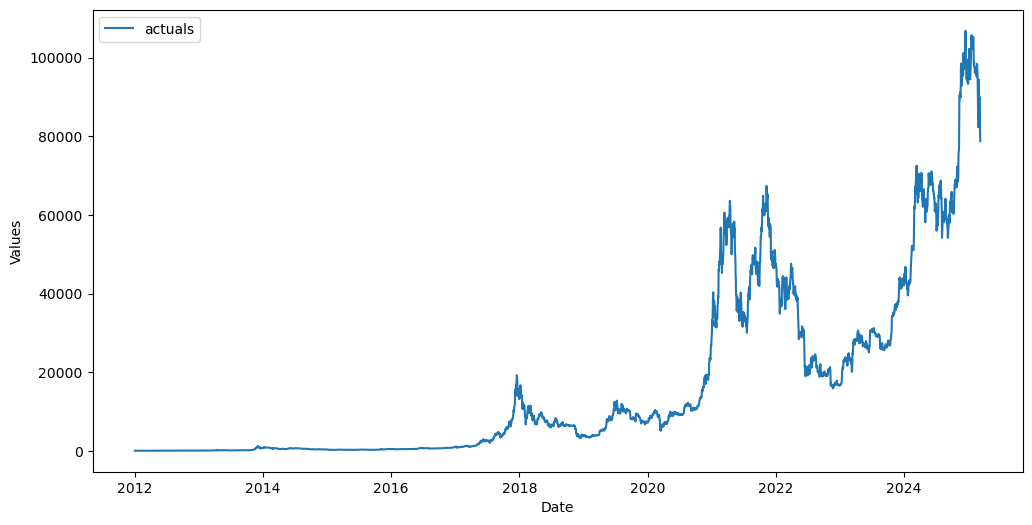

In [17]:
f.plot();

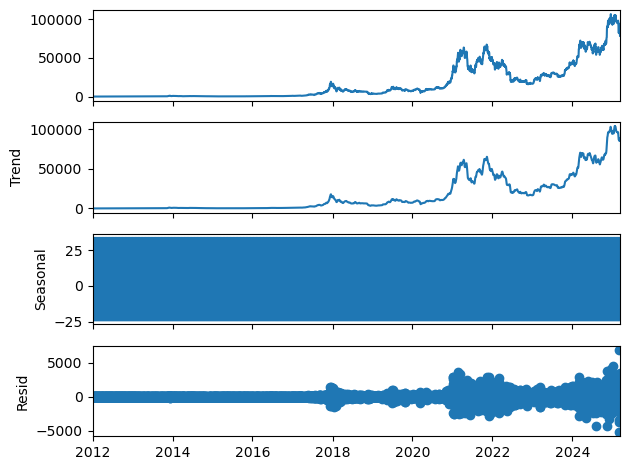

In [5]:
f.seasonal_decompose().plot()
plt.show()

In [7]:
f.add_ar_terms(3) 
f.add_AR_terms((12, 30))
f.add_AR_terms((2, 365))

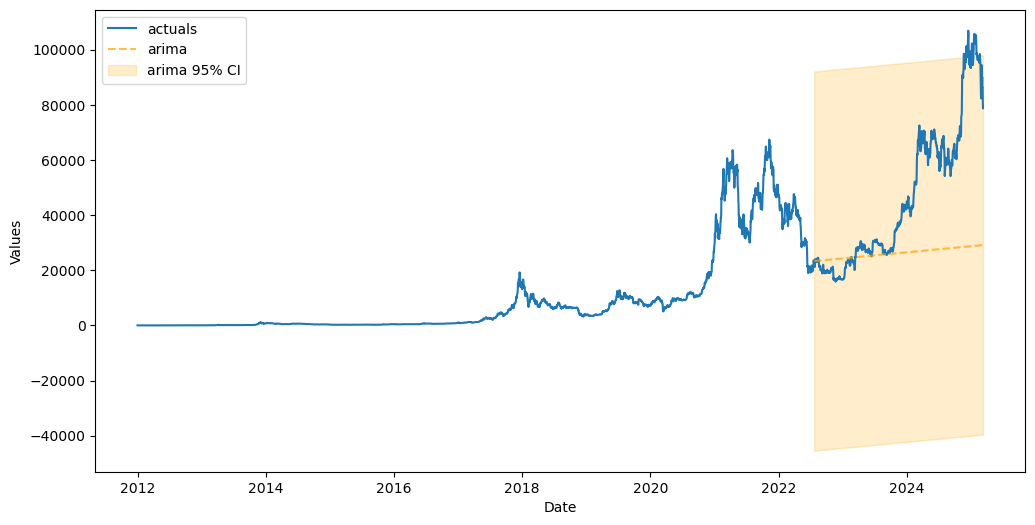

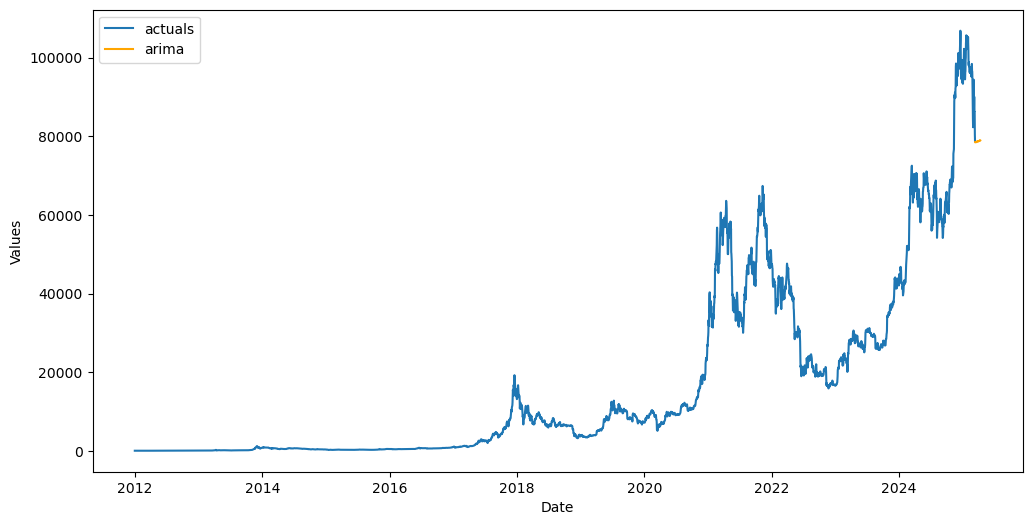

In [8]:
f.set_estimator('arima') # select an estimator
f.cross_validate(k=3) # tune model hyperparams using time series cross validation
f.auto_forecast() # automatically forecast with the chosen Xvars and hyperparams

# results = f.export(['lvl_fcsts','model_summaries']) # extract results
f.plot_test_set(ci=True, models=['arima'])
f.plot(models=['arima']);

In [7]:
adf, pval, usedlag, nobs, crit_vals, icbest = f.adf_test(full_res=True)
print('ADF test statistic: ', adf)
print('ADF p-value: ', pval)
print('Number of lags used: ', usedlag)
print('Number of observations: ', nobs)
print('Critical values: ', crit_vals)
print('Best information criterion: ', icbest)

ADF test statistic:  -0.8299296608933938
ADF p-value:  0.8101720027896546
Number of lags used:  31
Number of observations:  4787
Critical values:  {'1%': -3.4317167871415677, '5%': -2.862143966205577, '10%': -2.567091492959594}
Best information criterion:  76847.07668795223


<AxesSubplot: xlabel='Date', ylabel='Values'>

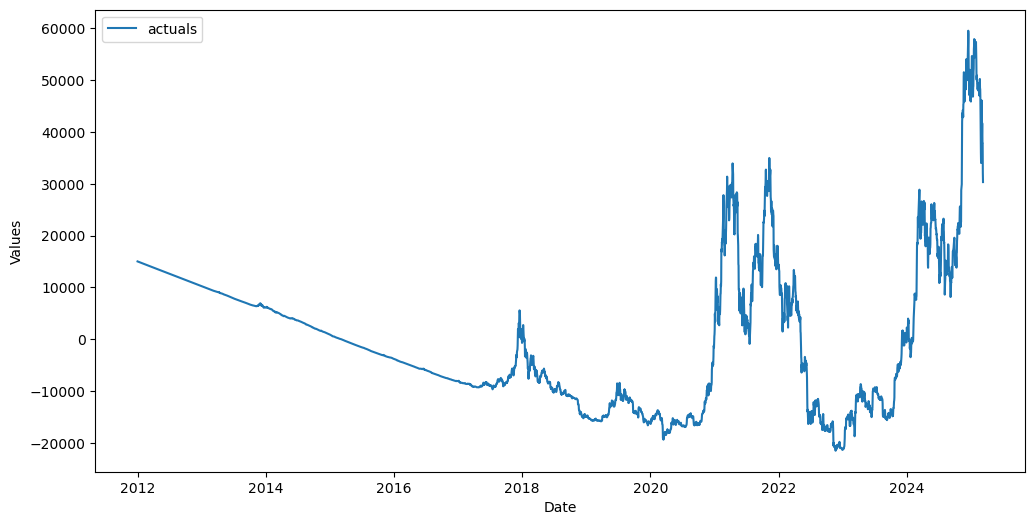

In [13]:
transformer = SeriesTransformer(f)
f_detrended = transformer.DetrendTransform(m=365)
f_detrended.plot()

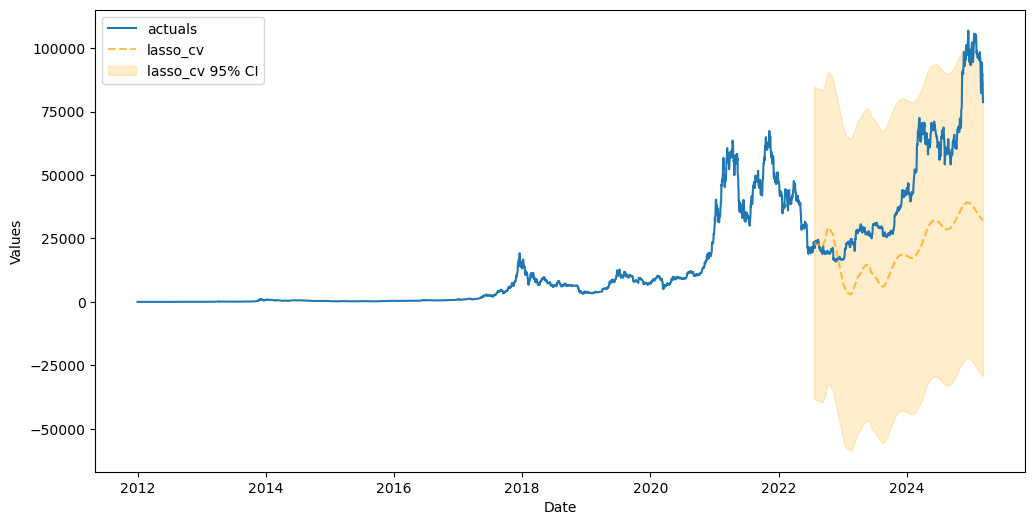

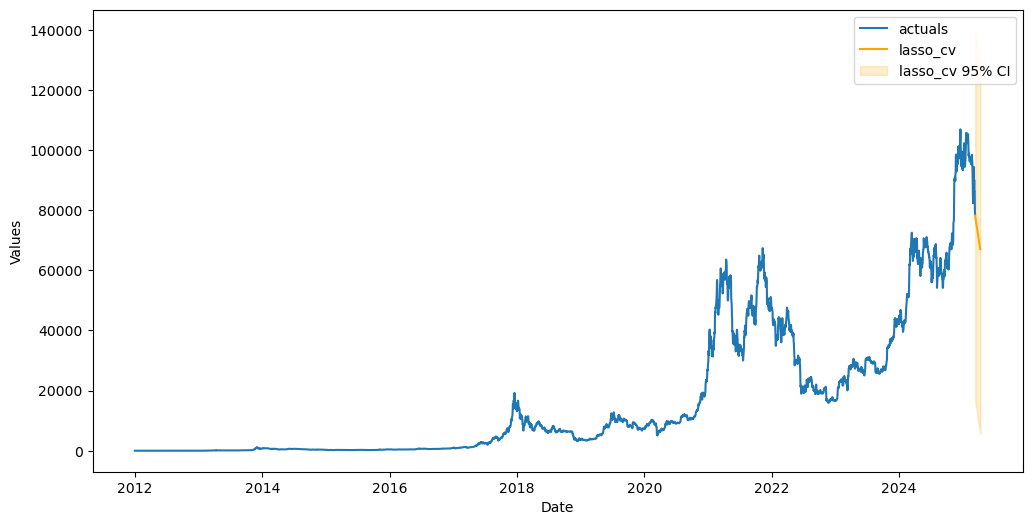

In [9]:
f.set_estimator('lasso')
# lasso_grid = {'alpha':np.linspace(0,2,100)}
# f.ingest_grid(lasso_grid)
f.cross_validate(k=3)
f.auto_forecast(call_me="lasso_cv")

f.plot_test_set(ci=True, models='lasso_cv')
f.plot(models='lasso_cv', ci=True)
plt.show()

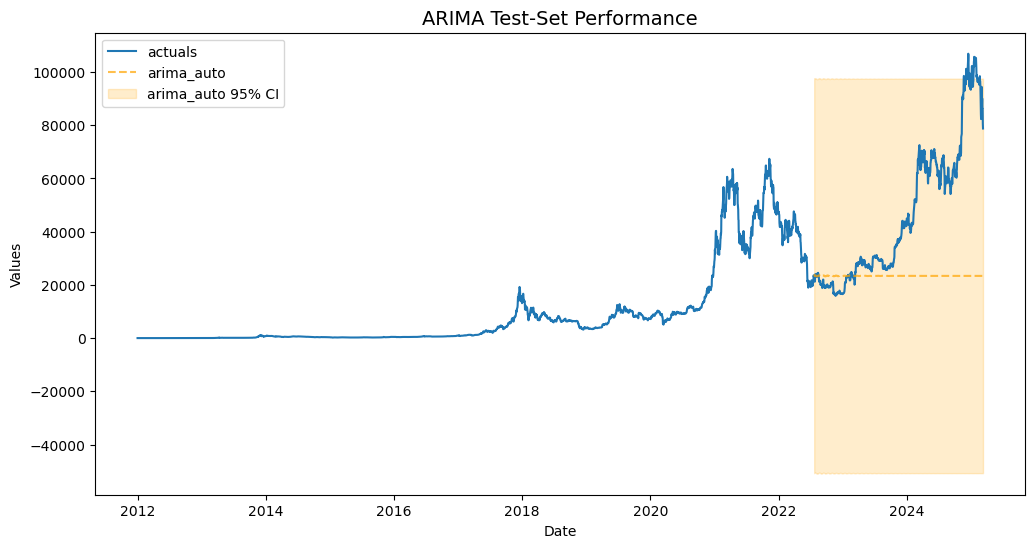

<AxesSubplot: xlabel='Date', ylabel='Values'>

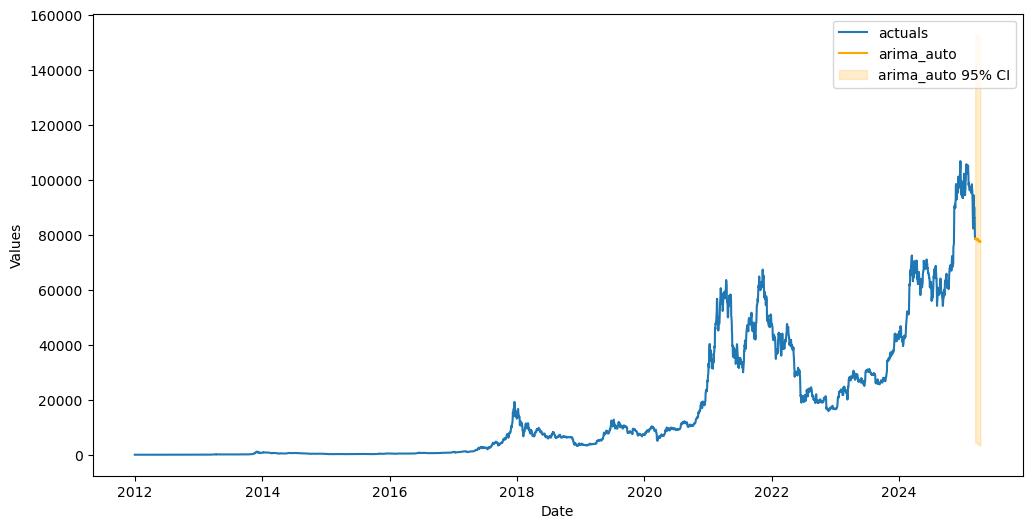

In [11]:
auto_arima(f, m=12, call_me='arima_auto')
f.plot_test_set(ci=True,models='arima_auto')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()
f.plot(models=['arima_auto'], ci=True)